In [12]:
import pandas as pd
import numpy as np

### 시각화 라이브러리 정의
# - 파이썬에서 사용되는 기본 시각화 라이브러리
import matplotlib.pyplot as plt

# - 히트맵 라이브러리
import seaborn as sns
import geopandas as gpd
import folium
from shapely.geometry import Polygon
from shapely.geometry import Point
from folium.plugins import MarkerCluster

import os
from dask.diagnostics import ProgressBar
import dask.dataframe as dd


from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from scipy.stats import spearmanr

import dask.dataframe as dd
from sklearn.model_selection import train_test_split
from dask_ml.wrappers import Incremental
from sklearn.ensemble import RandomForestRegressor
from dask_ml.model_selection import GridSearchCV
from dask.diagnostics import ProgressBar

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import set_config
import joblib  # 모델 저장용
import webbrowser

from model_class import Models


### 한글처리
plt.rc("font", family="Malgun Gothic")

# - 마이너스 기호 깨짐 처리
plt.rcParams["axes.unicode_minus"] = False

In [2]:
wildfire = pd.read_csv("./USA data/merged_fire.csv")
wildfire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900596 entries, 0 to 900595
Data columns (total 29 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   latitude               900596 non-null  float64
 1   longitude              900596 non-null  float64
 2   brightness             900596 non-null  float64
 3   bright_t31             900596 non-null  float64
 4   frp                    900596 non-null  float64
 5   T2M                    900596 non-null  float64
 6   WS2M                   900596 non-null  float64
 7   RH2M                   900596 non-null  float64
 8   PRECTOTCORR            900596 non-null  float64
 9   confidence_h           900596 non-null  float64
 10  confidence_l           900596 non-null  float64
 11  confidence_n           900596 non-null  float64
 12  daynight_D             900596 non-null  float64
 13  daynight_N             900596 non-null  float64
 14  year                   900596 non-nu

In [3]:
# 데이터를 병합 하며 결측치가 생겨 결측값 제거
wildfire = wildfire.dropna()

# 독립 변수(X): float64 타입만 추출, predicted_area_km2 제외
numeric_columns = wildfire.select_dtypes(include=['float64']).columns
X = wildfire[numeric_columns.drop('predicted_area_km2')]
y = wildfire['predicted_area_km2']

# 스피어만 상관계수 계산
print("스피어만 상관관계 분석 결과 (결측값 제거 후):")
print("-" * 50)

for value in X.columns:
    statistic, pvalue = spearmanr(X[value], y)
    
    # 출력
    if pvalue < 0.05 and abs(statistic) >= 0.2:
        print(f"상관관계 계수 {statistic:.3f}, p-value {pvalue:.4f} : ({value})는 predicted_area_km2에 대해 유의미하다 (강한 상관관계)")
    elif pvalue < 0.05:
        print(f"상관관계 계수 {statistic:.3f}, p-value {pvalue:.4f} : ({value})는 predicted_area_km2에 대해 약한 상관관계 (유의미)")
    else:
        print(f"상관관계 계수 {statistic:.3f}, p-value {pvalue:.4f} : ({value})는 predicted_area_km2에 대해 유의미하지 않다")

print("-" * 50)

스피어만 상관관계 분석 결과 (결측값 제거 후):
--------------------------------------------------
상관관계 계수 0.064, p-value 0.0000 : (latitude)는 predicted_area_km2에 대해 약한 상관관계 (유의미)
상관관계 계수 -0.011, p-value 0.0000 : (longitude)는 predicted_area_km2에 대해 약한 상관관계 (유의미)
상관관계 계수 0.813, p-value 0.0000 : (brightness)는 predicted_area_km2에 대해 유의미하다 (강한 상관관계)
상관관계 계수 0.640, p-value 0.0000 : (bright_t31)는 predicted_area_km2에 대해 유의미하다 (강한 상관관계)
상관관계 계수 1.000, p-value 0.0000 : (frp)는 predicted_area_km2에 대해 유의미하다 (강한 상관관계)
상관관계 계수 0.154, p-value 0.0000 : (T2M)는 predicted_area_km2에 대해 약한 상관관계 (유의미)
상관관계 계수 -0.026, p-value 0.0000 : (WS2M)는 predicted_area_km2에 대해 약한 상관관계 (유의미)
상관관계 계수 -0.198, p-value 0.0000 : (RH2M)는 predicted_area_km2에 대해 약한 상관관계 (유의미)
상관관계 계수 -0.073, p-value 0.0000 : (PRECTOTCORR)는 predicted_area_km2에 대해 약한 상관관계 (유의미)
상관관계 계수 0.339, p-value 0.0000 : (confidence_h)는 predicted_area_km2에 대해 유의미하다 (강한 상관관계)
상관관계 계수 0.202, p-value 0.0000 : (confidence_l)는 predicted_area_km2에 대해 유의미하다 (강한 상관관계)
상관관계 계수 -0.404, p-

In [19]:
train_cols = [
    "frp",           # 강한 상관관계
    "brightness",    # 강한 상관관계
    "bright_t31",    # 강한 상관관계
    "confidence_h",  # 강한 상관관계
    "confidence_l",  # 강한 상관관계
    "confidence_n",  # 강한 상관관계
    "daynight_D",    # 강한 상관관계
    "daynight_N",    # 강한 상관관계
    "latitude",      # 약한 상관관계
    "longitude",     # 약한 상관관계
    "T2M",           # 약한 상관관계
    "WS2M",          # 약한 상관관계
    "RH2M",          # 약한 상관관계
    "PRECTOTCORR",   # 약한 상관관계
    "year",          # 약한 상관관계
    "month",         # 약한 상관관계
    "day",           # 약한 상관관계
    "season",        # 약한 상관관계
    "weekday",       # 약한 상관관계
    "WS2M_RH2M_interaction",  # 약한 상관관계
    "high_temperature",       # 약한 상관관계
    "precipitation_flag"      # 약한 상관관계
]

# 데이터 준비
train = wildfire[train_cols]
target = wildfire["predicted_area_km2"]

# 첫 번째 분할 (훈련 데이터와 검증 데이터)
train_input, val_input, train_target, val_target = train_test_split(train, target, test_size=0.4, random_state=42, shuffle=True)

# 두 번째 분할 (검증 데이터와 테스트 데이터)
val_input, test_input, val_target, test_target = train_test_split(val_input, val_target, test_size=0.5, random_state=42, shuffle=True)

print(train_input.shape, train_target.shape)
print(val_input.shape, val_target.shape)
print(test_input.shape, test_target.shape)


(540357, 22) (540357,)
(180119, 22) (180119,)
(180120, 22) (180120,)


In [ ]:
rf = RandomForestRegressor() 

rf.fit(train_input, train_target)

train_score = rf.score(train_input, train_target)
val_score = rf.score(val_input, val_target)
test_score = rf.score(test_input, test_target)

print(f"train_score: {train_score}, val_score: {val_score}, test_score: {test_score}, 과적합여부: {train_score - val_score}")

train_score: 0.9999999997156066, val_score: 0.9999999978892833, test_score: 0.9999999981095657, 과적합여부: 1.8263233148019253e-09


In [5]:
models = Models()
models.total_models(train_input, train_target, val_input, val_target, test_input, test_target)

Tuning and training RandomForest with None...
Best Parameters for RandomForest: {'n_estimators': 200, 'min_samples_split': 5, 'max_depth': 20}
-*** RandomForest with None ***-
훈련: 1.0000, 검증: 1.0000, 테스트: 1.0000, 과적합여부: 0.0000
사용 가능한 모델입니다 (일반화).

Saved RandomForest with None as final model.
Tuning and training HistGradientBoosting with None...
Best Parameters for HistGradientBoosting: {'max_iter': 200, 'max_depth': 5, 'learning_rate': 0.1}
-*** HistGradientBoosting with None ***-
훈련: 0.9993, 검증: 0.9992, 테스트: 0.9993, 과적합여부: 0.0001
사용 가능한 모델입니다 (일반화).

Saved HistGradientBoosting with None as final model.
Tuning and training XGB with None...
Best Parameters for XGB: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1}
-*** XGB with None ***-
훈련: 0.9995, 검증: 0.9993, 테스트: 0.9993, 과적합여부: 0.0002
사용 가능한 모델입니다 (일반화).

Saved XGB with None as final model.
Tuning and training RandomForest with Standard...
Best Parameters for RandomForest: {'n_estimators': 200, 'min_sample

In [7]:
results_df = models.get_results()
results_df

,model_nm,Scaler,GSCV,train_score,val_score,test_score,과적합여부,사용,train_mae,train_mse,train_r2,val_mae,val_mse,val_r2,test_mae,test_mse,test_r2
0,RandomForest,None,Y,1.000000,1.000000,1.000000,2.596818e-09,Y,0.000006,3.192137e-09,1.000000,0.000012,1.326883e-08,1.000000,0.000012,1.307440e-08,1.000000
1,HistGradientBoosting,None,Y,0.999337,0.999243,0.999261,9.402568e-05,Y,0.011378,2.615036e-03,0.999337,0.011847,2.950166e-03,0.999243,0.011656,2.903525e-03,0.999261
2,XGB,None,Y,0.999490,0.999275,0.999307,2.152191e-04,Y,0.009863,2.008444e-03,0.999490,0.011054,2.822840e-03,0.999275,0.010813,2.723067e-03,0.999307
3,RandomForest,Standard,Y,1.000000,1.000000,1.000000,2.578741e-09,Y,0.000006,3.227582e-09,1.000000,0.000012,1.323345e-08,1.000000,0.000012,1.318145e-08,1.000000
4,HistGradientBoosting,Standard,Y,0.999345,0.999242,0.999262,1.024041e-04,Y,0.011331,2.582391e-03,0.999345,0.011857,2.950544e-03,0.999242,0.011660,2.898346e-03,0.999262
5,XGB,Standard,Y,0.999489,0.999282,0.999314,2.068127e-04,Y,0.009866,2.015077e-03,0.999489,0.011046,2.796651e-03,0.999282,0.010787,2.695165e-03,0.999314
6,RandomForest,MinMax,Y,1.000000,1.000000,1.000000,2.620568e-09,Y,0.000006,3.236802e-09,1.000000,0.000012,1.340547e-08,1.000000,0.000012,1.265128e-08,1.000000
7,HistGradientBoosting,MinMax,Y,0.999341,0.999242,0.999262,9.884255e-05,Y,0.011368,2.598680e-03,0.999341,0.011877,2.952767e-03,0.999242,0.011683,2.900313e-03,0.999262
8,XGB,MinMax,Y,0.999490,0.999277,0.999310,2.126000e-04,Y,0.009859,2.010687e-03,0.999490,0.011033,2.814854e-03,0.999277,0.010789,2.709682e-03,0.999310
9,RandomForest,Robust,Y,1.000000,1.000000,1.000000,2.512361e-09,Y,0.000006,3.163668e-09,1.000000,0.000012,1.291174e-08,1.000000,0.000012,1.296350e-08,1.000000


In [ ]:
results_df.to_csv("model_results_final.csv", index=False)

모델 로드 완료: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)
예측 결과 샘플: [0.8894198  0.8884208  0.9434862  0.94536674 0.8771455 ]


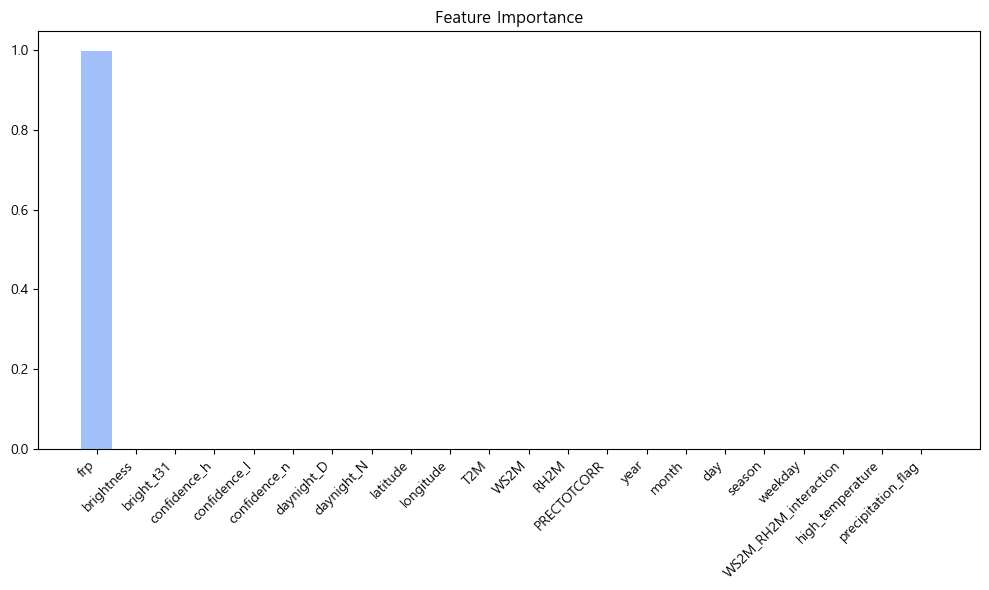

In [10]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import folium

# 모델 불러오기
model_path = "XGB_Standard_final_model.pkl"
best_model = joblib.load(model_path)
print("모델 로드 완료:", best_model)

# 데이터 준비
wildfire = pd.read_csv("./USA data/merged_fire.csv").dropna()

# 학습 때 사용한 22개 피처
train_cols = [
    "frp", "brightness", "bright_t31", "confidence_h", "confidence_l", "confidence_n",
    "daynight_D", "daynight_N", "latitude", "longitude", "T2M", "WS2M", "RH2M",
    "PRECTOTCORR", "year", "month", "day", "season", "weekday", "WS2M_RH2M_interaction",
    "high_temperature", "precipitation_flag"
]
test_data = wildfire[train_cols]

# 스케일링 (StandardScaler 사용)
scaler = StandardScaler()
scaler.fit(test_data)  # 학습 때 저장된 스케일러 없으니 새로 fit (최적은 학습 데이터로 fit)
test_scaled = scaler.transform(test_data)
predictions = best_model.predict(test_scaled)
print("예측 결과 샘플:", predictions[:5])

# 피처 중요도 분석
feature_names = train_cols
importances = best_model.feature_importances_
plt.figure(figsize=(10, 6))
plt.bar(feature_names, importances, color="#A3BFFA")
plt.title("Feature Importance")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("feature_importance.png")
plt.show()

In [11]:
# 예측 결과 시각화
wildfire_with_pred = wildfire[["latitude", "longitude"]].copy()
wildfire_with_pred["predicted_area_km2"] = predictions

m = folium.Map(location=[34.0, -118.0], zoom_start=5)
for idx, row in wildfire_with_pred.sample(1000).iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=max(row["predicted_area_km2"] / 1000, 1),
        color="#B2F5EA",
        fill=True,
        fill_color="#B2F5EA",
        popup=f"Predicted Area: {row['predicted_area_km2']:.2f} km²"
    ).add_to(m)
m.save("predicted_fire_map.html")
print("지도 저장 완료.")

지도 저장 완료.


In [13]:
# 지도 저장 및 열기
output_file = "fire_map_geojson.html"
m.save(output_file)
file_path = os.path.abspath(output_file)
webbrowser.open(f"file://{file_path}")

print(f"Map saved as {output_file} and opened in browser")

Map saved as fire_map_geojson.html and opened in browser


In [14]:
print(wildfire["predicted_area_km2"].describe())
print("예측값 분포:", pd.Series(predictions).describe())

count    900596.000000
mean          1.552286
std           1.982428
min           0.784137
25%           0.842586
50%           0.930608
75%           1.233068
max          12.546194
Name: predicted_area_km2, dtype: float64
예측값 분포: count    900596.000000
mean          1.553172
std           1.983387
min           0.773395
25%           0.843393
50%           0.929832
75%           1.228925
max          12.683393
dtype: float64


In [15]:
m = folium.Map(location=[34.0, -118.0], zoom_start=5)
for idx, row in wildfire_with_pred.sample(100).iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=max(row["predicted_area_km2"] * 10, 1),  # 스케일 조정
        color="#FF0000",  # 빨간색으로 변경
        fill=True,
        fill_color="#FF0000",
        popup=f"Predicted Area: {row['predicted_area_km2']:.2f} km²"
    ).add_to(m)
m.save("predicted_fire_map.html")
print("지도 재저장 완료.")

지도 재저장 완료.


In [16]:
# 지도 저장 및 열기
output_file = "fire_map_geojson.html"
m.save(output_file)
file_path = os.path.abspath(output_file)
webbrowser.open(f"file://{file_path}")

print(f"Map saved as {output_file} and opened in browser")

Map saved as fire_map_geojson.html and opened in browser
